In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

# ARIMA Modeling

So far we've talked about some of the basics of modeling time with seasonality indicators or oscilating curves. There is one more key branch of time series modeling we need to address, which has to do with random movement rather than seasonality. Here, we'll be talking about time series that are observed at regular intervals. What that interval is doesn't matter nearly as much as its consistency.

Now, the simplest way to approach the evolution of a process is with a single trend term. This would typically imply some kind of linear relationship between time and your outcome. As time moves forward the outcome changes at a given rate per unit of time.

However, this is not always how we want to model this kind of temporal evolution because our movement is random rather than deterministic. Sometimes, we want to say that a certain set of previous values influence our next outcome. We look back a certain distance to see how we want to look forward. This allows us to adjust to shocks or changes to our system, and lets outliers fade from influence over time, well incorporating and understanding the underlying effects within the randomness.

How do we do this? The most fundamental technique is another extension of least squares regression called ARIMA (or its  variations ARMA and ARIMAx) modeling. ARMA allows for two additional kinds of terms to be added to our specifications: auto regressions and moving averages. Both of these models generally apply to stationary processes, a key attribute that could use a bit more explanation before we go too much further.

## Stationarity and Differencing

Now, as we said above we need the data for ARIMA to be stationary. There is, thankfully, an easy way to do this. It's called __differencing__. All this means is subtracting each term from its following term. If there is a constant linear trend, then that difference has a constant expectation.

This is also extendable. If the rate of change is increasing at a constant rate, then taking the difference in differences yields a stationary time series.

So what are we left with after differencing? Our goal is to be left with a random stationary process. Now, just because our process is stationary doesn't mean our expected value of our difference is zero. If it was we'd probably have been stationary in the first place. Instead we may have a constant expected value. That would be the drift of our original process, or how much that process is moving on average per time period.

That kind of process, however, is ready for autoregressive modeling.

## Autoregressive Models

An autoregressive model is simply a linear model where the terms of interest are the previous values of the outcome. Simply put we could say the outcome today is based on yesterday's outcome and some random noise term.

$$ X_{t} = \alpha + \beta X_{t-1} + \epsilon $$

Here the $\epsilon$ is our noise term, and $\alpha$ is some constant or adjustment factor. $\beta$ is then the amount that the previous value influences our next value.

Let's simulate an autoregressive model below:

In [2]:
x_ar = [15]
for i in range(500):
    y = 5 + .7*x_ar[i-1] 
    x_ar.append(float(y))
    

In [6]:
x_ar[0:10]

[15, 15.5, 15.5, 15.85, 15.85, 16.095, 16.095, 16.2665, 16.2665, 16.38655]

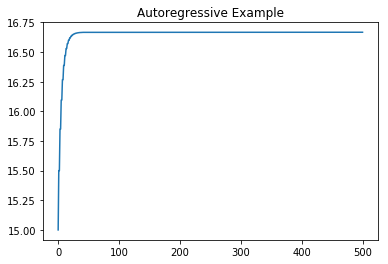

In [4]:
plt.plot(x_ar)
plt.title('Autoregressive Example')
plt.show()

Here we have our random movement generated from an autoregressive model. Specifically this model is referred to as AR(1), because we are only regressing on one of the previous terms, the first one. Autoregressive models are generalized to AR(n), where n is the number of autoregressive terms included, also called the order. In autoregressive models, we don't skip terms generally speaking, so AR(n) also implies that the terms are the lags of 1 through n. We also have a $\beta$ of .7 and a constant $\alpha$ of 5. The movement therefore comes from the random error, which in our case is implemented with a standard normal.

Look at the code and try changing the $\beta$ value. 

What happens if it's 1?

What about >1?

What does it look like if the $\beta$ is 1 and the $\alpha$ is 0?

## Moving Average

The other key component of ARMA modeling is the moving average. Here, we shift our focus from the previous term to the previous error. Let's start with an example.

In [31]:
x_ma = [15]
e_t = 0
for i in range(500):
    e = np.random.randn(1)
    y = 1 + .3*e_t + e
    x_ma.append(float(y))
    e_t=e

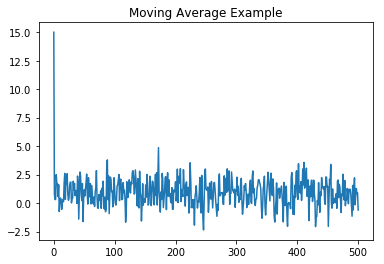

In [32]:
plt.plot(x_ma)
plt.title('Moving Average Example')
plt.show()

Here we have a moving average centered around 5. A moving average model sees the following specification:

$$ X_{t} = \alpha + \beta \epsilon_{t-1} + \epsilon_{t} $$

Again this is a MA(1) model, where you can make your next term dependent on as many previous errors as necessary, defined as an MA(n) model.

Play around with the values again. How does changing $\beta$ affect the process? What about $\alpha$?

## ARMA Modeling

Now, you can combine these two classes of coefficient into a single model to create an ARMA model. The ARMA model will be defined in two terms p and q. p is the order of the autoregressive compenent, q the order of the moving average component. This will be written as ARMA(p,q). An ARMA(1,1), for example, has the specification:

$$ X_{t} = \alpha + \beta_{1} X_{t-1} + \beta_{2} \epsilon_{t-1} + \epsilon_{t} $$

## Finding the Order

So now that we have these classes of model, we need to figure out how to find the order of a model from data. For ARIMA, we'll use statsmodels to both implement and analyze the data sets. If you want to use sklearn you have to rederive columns for ar and ma terms yourself.

What we'll use is a partial autocorrelation function. This takes the correlation of our time series with a lagged version of itself. Each bar represents the correlation with another lag. So the pacf at 1 is the correlation of our initial series with itself lagged by one. Hence for these kinds of plots, 0 will always return 1, since the time series perfectly correlates with itself.

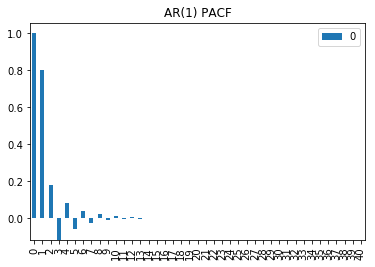

In [33]:
from statsmodels.tsa.stattools import acf, pacf
x_acf = pd.DataFrame(pacf(x_ar))
x_acf.plot(kind='bar')
plt.title("AR(1) PACF")

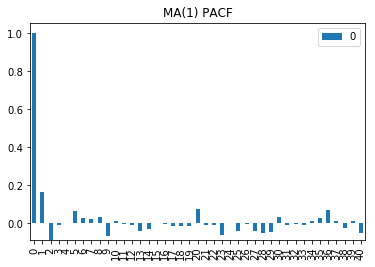

In [34]:
x_acf = pd.DataFrame(pacf(x_ma))
x_acf.plot(kind='bar')
plt.title('MA(1) PACF')

What do these plots mean? Rather than looking for a specific value, what we want to see is where values are outliers. This would indicate a possibly strong autocorrelation. For example, in the AR plot, clearly 2 is a strong autocorrelation. In the MA plot, we 1 would seem to be strong. This indicates that we should look into a p of 2 and 1 respectively for our models.

## There's no I in ARMA, but there in one in ARIMA... 

What if all the values are high? Well that likely means you need to use differences, which would come from either manually creating differences or using the ARIMA models and implementing the I aspect, which we haven't discussed but is well explained either here or as the level of differencing (1 being a simple difference, 2 the difference of differences, etc). You can keep taking differences until you get to a stationary process, though it's probably a pretty good idea to make sure there is a logical reason for that degree of differencing. Chances are, there's nothing in the process that makes an I of 27 logical, even if it looks like it may work.

There are other techniques for finding these parameters as well. Most powerful is still grid search and trial and error, attempting several reasonable combinations of p and q and seeing which seems to best match your data. You could also use information criteria, explained [here](https://coolstatsblog.com/2013/08/14/using-aic-to-test-arima-models-2/). Next, we'll take all of this theory and implement it in practice, building a model for the price of an exchange traded stock.